In [1]:
class Node:
    def __init__(self, inputs=[],name = ''):
        self.inputs = inputs
        self.value = None
        self.outputs = []
        self.gradients = {}
        self.name = name
        
        for node in self.inputs:#对当前节点的input节点，把它们的output设置成当前节点，建立连接关系
            node.outputs.append(self)
            
    def forward(self):
        raise NotImplemented
        
    def backward(self):
        raise NotImplemented
        
    def __repr__(self):
        return 'Node:{}'.format(self.name)
        
    

In [2]:
class Input(Node):
    def __init__(self, name = ''):
        Node.__init__(self,inputs = [])
        self.name = name
        
    def forward(self, value = None):
        if value is not None:
            self.value = value
            
    def backward(self):
        self.gradients = {}
        
        for n in self.outputs:
            grad_cost = n.gradients[self]
            self.gradients[self] = grad_cost
    
    def __repr__(self):
        return 'Input Node:{}'.format(self.name)
    

In [3]:
class Linear(Node):
    def __init__(self, nodes, weights, bias,name = ''):
        self.w_node = weights
        self.x_node = nodes
        self.b_node = bias
        Node.__init__(self, inputs = [nodes, weights, bias],name=name)
        
    def forward(self):
        self.value = np.dot(self.x_node.value, self.w_node.value) + self.b_node.value

    def backward(self):
        for node in self.outputs:
            grad_cost = node.gradients[self]
            self.gradients[self.w_node] = np.dot(self.x_node.value.T, grad_cost)
            self.gradients[self.b_node] = np.sum(grad_cost * 1, axis = 0, keepdims = False)
            self.gradients[self.x_node] = np.dot(grad_cost, self.w_node.value.T)

In [4]:
class Sigmoid(Node):
    def __init__(self, node):
        Node.__init__(self,[node])
        self.x_node = node
        
    def _sigmoid(self, x):
        return 1. / (1 + np.exp(-1 * x))
    
    def forward(self):
        self.value = self._sigmoid(self.x_node.value)
        
    def backward(self):
        y = self.value
        
        self.partial = y * (1 - y)
        
        for n in self.outputs:
            grad_cost = n.gradients[self]
            self.gradients[self.x_node] = grad_cost * self.partial

In [5]:
class MSE(Node):
    def __init__(self, y_true, y_hat):
        self.y_true_node = y_true
        self.y_hat_node = y_hat
        Node.__init__(self,inputs=[y_true, y_hat])
        
    def forward(self):
        y_true_flatten = self.y_true_node.value.reshape(-1, 1)
        y_hat_flatten = self.y_hat_node.value.reshape(-1, 1)
        self.diff = y_true_flatten - y_hat_flatten
        self.value = np.mean(self.diff**2)
        
    def backward(self):
        n = self.y_hat_node.value.shape[0]
        self.gradients[self.y_true_node] = (2 / n) * self.diff
        self.gradients[self.y_hat_node] = (-2 / n) * self.diff 
                 

In [6]:
def training_one_batch(topological_sorted_graph):
    for node in topological_sorted_graph:
        node.forward()
        
    for node in topological_sorted_graph[::-1]:
        #print(node)
        node.backward()

In [7]:
def topological_sort(data_with_value):
    feed_dict = data_with_value
    input_nodes = [n for n in feed_dict.keys()]
    
    G = {}
    nodes = [n for n in input_nodes]
    while len(nodes) > 0:
        print('enter while:')
        print(nodes)
        n = nodes.pop(0)
        print(nodes)
        if n not in G:
            G[n] = {'in':set(),'out': set()}
        for m in n.outputs:
            print(m)
            if m not in G:
                G[m] = {'in':set(),'out':set()}
            G[n]['out'].add(m)
            G[m]['in'].add(n)
            nodes.append(m)
            
    L = []
    S = set(input_nodes)
    while len(S) > 0:
        n = S.pop()
        
        if isinstance(n, Input):
            n.value = feed_dict[n]
        L.append(n)
        for m in n.outputs:
            G[n]['out'].remove(m)
            G[m]['in'].remove(n)
            if len(G[m]['in']) == 0:
                S.add(m)
    return L

In [8]:
def sgd_update(trainable_nodes, learning_rate = 1e-2):
    for t in trainable_nodes:
        t.value += -1 * learning_rate * t.gradients[t]

In [9]:
from sklearn.datasets import load_boston

In [10]:
data = load_boston()

In [11]:
X_ = data['data']

In [12]:
y_ = data['target']

In [13]:
X_[0]

array([6.320e-03, 1.800e+01, 2.310e+00, 0.000e+00, 5.380e-01, 6.575e+00,
       6.520e+01, 4.090e+00, 1.000e+00, 2.960e+02, 1.530e+01, 3.969e+02,
       4.980e+00])

In [14]:
y_[0]

24.0

In [15]:
import numpy as np
X_ = (X_ - np.mean(X_, axis=0)) / np.std(X_, axis = 0)

In [16]:
n_features = X_.shape[1]

In [17]:
n_hidden = 10

In [18]:
W1_,b1_ = np.random.randn(n_features, n_hidden),np.zeros(n_hidden)

In [19]:
W2_,b2_ = np.random.randn(n_hidden,1),np.zeros(1)

In [20]:
X,y = Input(name='X'),Input(name='y')
W1, b1 = Input(name = 'W1'),Input(name = 'b1')
W2, b2 = Input(name = 'W2'),Input(name = 'b2')

In [21]:
linear_output = Linear(X, W1 ,b1,name='liner_ounput')
sigmoid_output = Sigmoid(linear_output)
yhat = Linear(sigmoid_output, W2, b2,name= 'yhat')
loss = MSE(y, yhat)

In [22]:
input_node_with_value = {
    X: X_,
    y: y_,
    W1: W1_,
    W2: W2_,
    b1: b1_,
    b2: b2_
}

In [23]:
graph = topological_sort(input_node_with_value)

enter while:
[Input Node:X, Input Node:y, Input Node:W1, Input Node:W2, Input Node:b1, Input Node:b2]
[Input Node:y, Input Node:W1, Input Node:W2, Input Node:b1, Input Node:b2]
Node:liner_ounput
enter while:
[Input Node:y, Input Node:W1, Input Node:W2, Input Node:b1, Input Node:b2, Node:liner_ounput]
[Input Node:W1, Input Node:W2, Input Node:b1, Input Node:b2, Node:liner_ounput]
Node:
enter while:
[Input Node:W1, Input Node:W2, Input Node:b1, Input Node:b2, Node:liner_ounput, Node:]
[Input Node:W2, Input Node:b1, Input Node:b2, Node:liner_ounput, Node:]
Node:liner_ounput
enter while:
[Input Node:W2, Input Node:b1, Input Node:b2, Node:liner_ounput, Node:, Node:liner_ounput]
[Input Node:b1, Input Node:b2, Node:liner_ounput, Node:, Node:liner_ounput]
Node:yhat
enter while:
[Input Node:b1, Input Node:b2, Node:liner_ounput, Node:, Node:liner_ounput, Node:yhat]
[Input Node:b2, Node:liner_ounput, Node:, Node:liner_ounput, Node:yhat]
Node:liner_ounput
enter while:
[Input Node:b2, Node:liner_ou

In [24]:
graph

[Input Node:b1,
 Input Node:b2,
 Input Node:W1,
 Input Node:X,
 Input Node:y,
 Input Node:W2,
 Node:liner_ounput,
 Node:,
 Node:yhat,
 Node:]

In [25]:
from sklearn.utils import resample


In [26]:
def run(dictionary):
    return topological_sort(dictionary)

In [27]:
losses = []
epochs = 5000

batch_size = 64

steps_per_epoch = X_.shape[0] // batch_size

for i in range(epochs):
    loss = 0
    for batch in range(steps_per_epoch):
        X_batch, y_batch = resample(X_, y_, n_samples = batch_size)
        X.value = X_batch
        y.value = y_batch
        training_one_batch(graph)
        learning_rate = 1e-3
        sgd_update(trainable_nodes=[W1,W2,b1,b2],learning_rate = learning_rate)
        loss += graph[-1].value
    if i % 100 == 0:
        print('Epoch:{}, loss = {:.3f}'.format(i+1, loss/steps_per_epoch))
        losses.append(loss)

Epoch:1, loss = 378.066
Epoch:101, loss = 34.209
Epoch:201, loss = 23.899
Epoch:301, loss = 21.003
Epoch:401, loss = 22.233
Epoch:501, loss = 14.706
Epoch:601, loss = 21.182
Epoch:701, loss = 14.006
Epoch:801, loss = 14.013
Epoch:901, loss = 15.395
Epoch:1001, loss = 13.267
Epoch:1101, loss = 11.777
Epoch:1201, loss = 11.144
Epoch:1301, loss = 11.930
Epoch:1401, loss = 11.978
Epoch:1501, loss = 8.312
Epoch:1601, loss = 9.216
Epoch:1701, loss = 10.355
Epoch:1801, loss = 11.013
Epoch:1901, loss = 10.716
Epoch:2001, loss = 8.395
Epoch:2101, loss = 8.017
Epoch:2201, loss = 8.809
Epoch:2301, loss = 7.424
Epoch:2401, loss = 12.757
Epoch:2501, loss = 8.696
Epoch:2601, loss = 9.046
Epoch:2701, loss = 8.916
Epoch:2801, loss = 7.352
Epoch:2901, loss = 9.329
Epoch:3001, loss = 8.630
Epoch:3101, loss = 7.597
Epoch:3201, loss = 5.585
Epoch:3301, loss = 8.009
Epoch:3401, loss = 6.809
Epoch:3501, loss = 6.518
Epoch:3601, loss = 7.647
Epoch:3701, loss = 7.235
Epoch:3801, loss = 8.018
Epoch:3901, loss 

In [28]:
import matplotlib.pyplot as plt

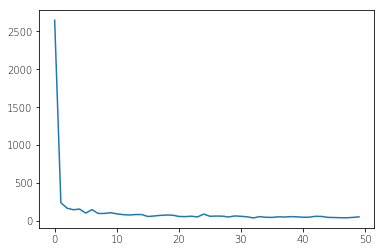

In [29]:
plt.plot(losses)

In [30]:
def _sigmoid(x):
    return 1. / (1 + np.exp(-1 * x))

In [31]:
np.dot(_sigmoid(np.dot(X_[1], W1.value) + b1.value), W2.value) + b2.value

array([24.13320866])

In [32]:
y_[1]

21.6